# POLI 175 - Lecture 11

## Regularization

# Linear Model Regularization

In this class, we are going to focus on two of the most used methods for model selection:
- **Ridge**
- **Lasso**

These methods are different from the subset selection in special ways:
- They are meant to "*shrink*" the coefficients toward zero!

It may be counter-intuitive, but these methods are great tools to reduce the variance of the estimates (recall the bias-variance trade-offs).

# Ridge Regression

## Ridge Regression

Instead of minimizing the RSS, one minimizes:

$$ \text{Residual Sum of Squares} + \underbrace{\alpha \ \sum_{j=1}^p\beta_j^2}_{\text{shrinkage penalty}} $$

The $\alpha \geq 0$ parameters is called *tuning parameter*. 

Selecting a good $\alpha$ is crucial for a good set of estimates.

The R-squared for this regression is: 0.7598079338837949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.22734e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


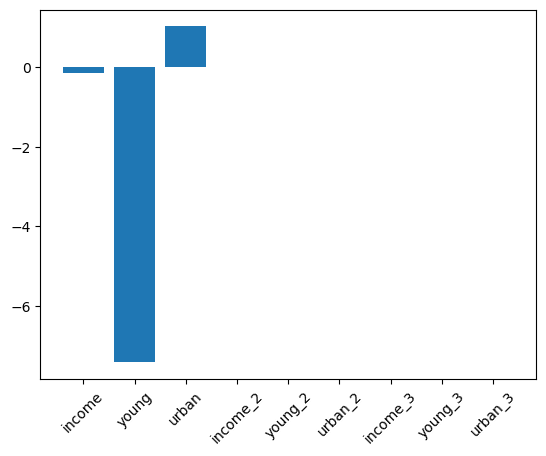

In [34]:
## Ridge Regression (badly done)
ridge = Ridge(alpha = 1).fit(X, y)
print('The R-squared for this regression is: ' + str(ridge.score(X, y)))
plt.bar(X.columns, ridge.coef_)
plt.xticks(rotation=45)
plt.show()

## Ridge Regression

$\alpha = 0$ is the same as the least square regression.

As $\alpha$ grows, the shrinkage penalty increases, and the ridge coefficients approach zero.

**Caveat 1**: The scale of the variable influences the results.

In a OLS (standard least square regression), when you multiply $x_j$ by $c \neq 0$, you divide $\beta_j$ by $\dfrac{1}{c}$.

Example: If you measure GDP in USD vs Millions of USD changes the ridge regression coefficient significantly.

**Suggestion**: Standardize the variables before running the regression

## Ridge Regression

### Standardization

Let a variable $x_j$. Then, the standardized variable $z_j$ is obtained by:
1. Subtracting the mean of the variable $x_j$ ($\overline{x}_j$) and then,
2. Dividing the result by the standard deviation ($\sigma_{x_j}$) of the variable $x_j$.

$$ z_j \ = \ \dfrac{x_j - \overline{x}_j}{\sigma_{x_j}} $$

The resulting variable $z_j$ has mean zero, variance one, and has no unit!

Variations of one unit are called *deviations*: In a regression with a standardized variable, we say that $\beta_j$ would represent a variation on average $y$ when we increase $z_j$ by one standard-deviation.

This is a great practice for prediction, but in general, be mindful about the unit of your data.

**Again:** In a standard least square regression, when you multiply $x_j$ by $c \neq 0$, you divide $\beta_j$ by $\dfrac{1}{c}$.

In [15]:
## Standardizing the X variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# First observation:
print(list(X.iloc[0]))
print(list(X_scaled[0])) 

[2824.0, 350.7, 508.0, 7974976.0, 122990.48999999999, 258064.0, 22521332224.0, 43132764.842999995, 131096512.0]
[-0.7236935623908923, -0.3450642975121714, -1.044417328024432, -0.7523179270273195, -0.3599514179092925, -1.03909576213098, -0.7617030030625055, -0.37201867365836544, -0.9953964232882246]


The R-squared for this regression is: 0.7062378535723208


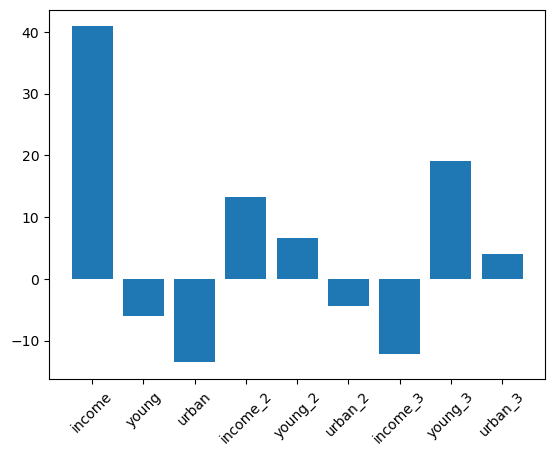

In [39]:
## Ridge Regression (greatly done)
ridge = Ridge(alpha = 1).fit(X_scaled, y)
print('The R-squared for this regression is: ' + str(ridge.score(X_scaled, y)))
plt.bar(X.columns, ridge.coef_)
plt.xticks(rotation=45)
plt.show()

## Ridge Regression

**Caveat 2**: The ridge regression produces a different set of parameter for each $\alpha$.
- $\widehat{\beta}_{\alpha}^{R}$

Also note that the intercept ($\beta_0$) is not considered.

- We do not want to shrink the mean of $y_i$ when $x_{ij} = 0$ for all $j$.

- And if we standardize the variables, then the intercept will be $\widehat{\beta}_0 = \overline{y}$.

## Ridge Regression (book calls the reg parameter $\lambda$)

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/ridge1.png?raw=true)

In [40]:
## Example by Kornel Kielczewski in the sklearn documentation, adapted by me.
ridge = Ridge()
coefs = list()
errors = list()
alphas = np.logspace(-6, 6, 200)

for a in alphas:
    ridge.set_params(alpha = a).fit(X_scaled, y)
    coefs.append(ridge.coef_)
    errors.append(np.mean((ridge.predict(X_scaled) - y) ** 2))

coefs = pd.DataFrame(coefs, columns = X.columns, index = alphas)
print(errors[0:5])
coefs.head()

[496.7541409012298, 496.75872644478574, 496.76468170844765, 496.7723978903649, 496.782369367379]


,income,young,urban,income_2,young_2,urban_2,income_3,young_3,urban_3
0.000001,-67.074874,-1972.450244,208.787188,383.996347,3780.872647,-537.149445,-276.113692,-1790.787122,316.455354
0.000001,-67.109924,-1962.809279,208.486396,383.999187,3761.703740,-536.490651,-276.099839,-1781.235925,316.110943
0.000001,-67.149365,-1951.852113,208.144395,384.001574,3739.917880,-535.741598,-276.083645,-1770.380803,315.719336
0.000002,-67.193605,-1939.418308,207.756115,384.003182,3715.196082,-534.891181,-276.064677,-1758.062820,315.274720
0.000002,-67.243043,-1925.333610,207.316035,384.003560,3687.191895,-533.927303,-276.042418,-1744.109358,314.770766


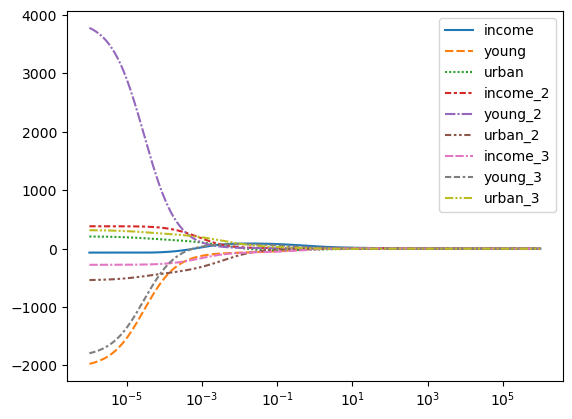

In [18]:
# Coefficients as a function of the regularization paramenter alpha
g = sns.lineplot(data = coefs)
g.set(xscale='log')
plt.show()

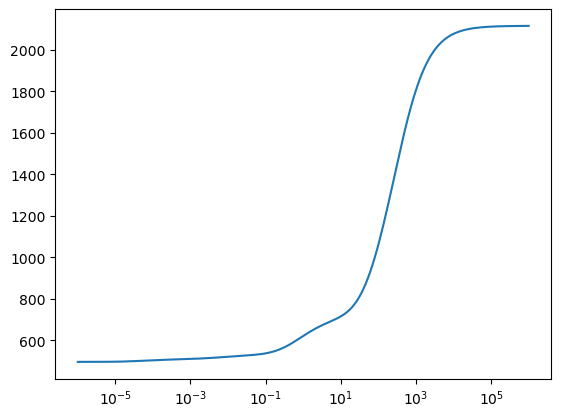

In [19]:
# Mean Squared Error as a function of the regularization paramenter alpha
g = sns.lineplot(x = alphas, y = errors)
g.set(xscale='log')
plt.show()

## Ridge Regression

Advantage: the *non-obvious* advantage is that as $\alpha$ increses, the flexibility of the model decreases.

This decreases variance (but increase bias).

This may be "optimized": You may find the optimal bias-variance trade-off by manipulating $\alpha$.

## Ridge Regression

Specially important when $p$ is close to $n$ (number of predictors is close to the number of cases).
- This is called *high dimensional data*.

If $p > n$, then ridge does very well. This case would have a very high variance.

And it is *way* better than *best subset selection*: you fit just one model:
- In practice, as many as the different $\alpha$s.
- There are algorithms to solve efficiently for all $\alpha$s, which means that it may be more efficient than best, forward, and backward stepwise selection.

## Ridge Regression (the book calls the regularization parameter $\lambda$) 

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/ridge2.png?raw=true)


# Cross-Validation

## Cross-Validation

To select the tuning parameters you can use cross-validation.

The idea is to search through a grid of tuning parameter candidates, selecting the one that does best in the cross-validation.

It is indeed a very straight-forward idea, if you think about it.

## Cross-Validation (the book calls the regularization parameter $\lambda$) 

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/cvridge.png?raw=true)

In [41]:
## Ridge with Cross-Validation
ridge = Ridge()
coefs = list()
errors = list()
CVerrors = list()
alphas = np.logspace(-6, 6, 200)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 12345)

for a in alphas:
    ridge.set_params(alpha = a).fit(X_train, y_train)
    CVerrors.append(np.mean((ridge.predict(X_test) - y_test) ** 2))
    errors.append(np.mean((ridge.predict(X_train) - y_train) ** 2))

print('The alpha that minimizes the ridge testing set MSE is: ' + str(alphas[CVerrors.index(min(CVerrors))]))
    
mses = pd.DataFrame({
    'trainMSE': errors,
    'testMSE': CVerrors}, index = alphas)

The alpha that minimizes the ridge testing set MSE is: 0.03827494478516307


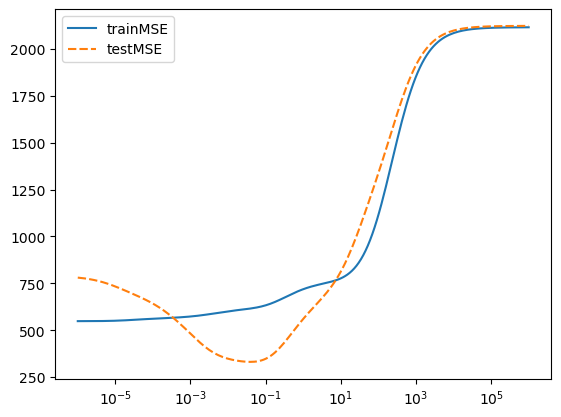

In [21]:
# Cross Validation Ridge MSE as a function of the regularization parameter alpha
g = sns.lineplot(data = mses)
g.set(xscale='log')
plt.show()

# Lasso Regression

# Lasso Regression

Ridge regression has one disadvantage: it always include $p$ predictors.

The shrinkage never sets coefficients to be exactly zero (that is, be removed from the prediction).

This could potentially make subset selection better than ridge.

## Lasso Regression

But one alternative, using the same principles as the ridge regression is the **Lasso** Regression.

In the lasso regression, the objective function becomes:

$$ \text{Residual Sum of Squares} + \alpha \sum_{j=1}^p|\beta_j| $$

Does the same as ridge: the larger the $\alpha$, the more the *shrinkage*.

## Lasso Regression

Unlike ridge, for some values of $\alpha$, **Lasso** actually force coefficients to be exactly equal to zero.

Thus, **Lasso** performs variable selection, much like the subset selection models we have seen.

**Side-effect**: Makes models easier to interpret!

- Yields *sparse* models: models that only involve a subset of the variables.
    
Like ridge, selecting a good $\alpha$ is critical.

The R-squared for this regression is: 0.7505141127635888


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e+04, tolerance: 1.079e+01
  model = cd_fast.enet_coordinate_descent(


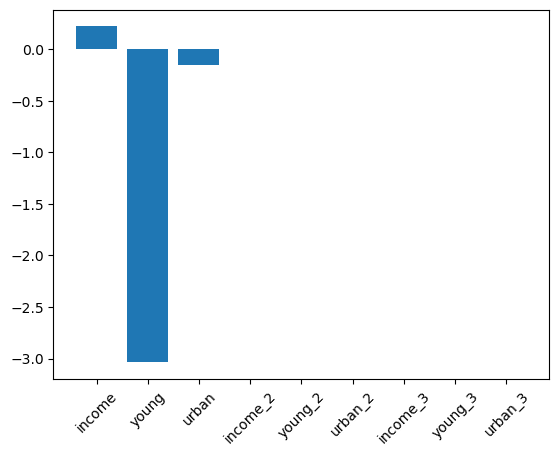

In [3]:
## Lasso Regression (badly done)
lasso = Lasso(alpha = 1).fit(X, y)
print('The R-squared for this regression is: ' + str(lasso.score(X, y)))
plt.bar(X.columns, lasso.coef_)
plt.xticks(rotation=45)
plt.show()

The R-squared for this regression is: 0.6965025797685898


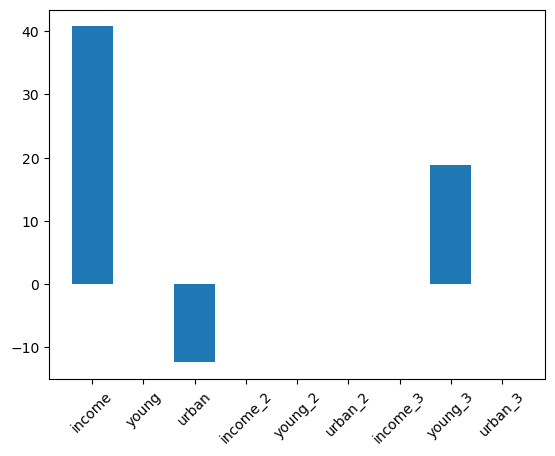

196.31372549019608
196.31372549019608


In [10]:
## Lasso Regression (greatly done)
lasso = Lasso(alpha = 1).fit(X_scaled, y)
print('The R-squared for this regression is: ' + str(lasso.score(X_scaled, y)))
plt.bar(X.columns, lasso.coef_)
plt.xticks(rotation=45)
plt.show()
print(lasso.intercept_)
print(np.mean(y))

## Lasso (the book calls the regularization parameter $\lambda$) 

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/lasso1.png?raw=true)

In [5]:
## Example by Kornel Kielczewski in the sklearn Ridge documentation, adapted by me.
lasso = Lasso(max_iter = 20000000)
coefs = list()
errors = list()
alphas = np.logspace(-6, 6, 200)

for a in alphas:
    lasso.set_params(alpha = a).fit(X_scaled, y)
    coefs.append(lasso.coef_)
    errors.append(np.mean((lasso.predict(X_scaled) - y) ** 2))

coefs = pd.DataFrame(coefs, columns = X.columns, index = alphas)
print(errors[0:5])
coefs.head()

[496.7391981233972, 496.73919989324065, 496.73920222958094, 496.73920531374625, 496.7392093851063]


,income,young,urban,income_2,young_2,urban_2,income_3,young_3,urban_3
0.000001,-66.792132,-2038.536608,210.834245,383.886449,3912.272581,-541.632507,-276.160246,-1856.260174,318.797890
0.000001,-66.787782,-2038.347428,210.826610,383.875788,3911.896663,-541.615738,-276.154241,-1856.072990,318.788988
0.000001,-66.782784,-2038.130069,210.817838,383.863538,3911.464753,-541.596470,-276.147341,-1855.857924,318.778759
0.000002,-66.777042,-2037.880335,210.807758,383.849464,3910.968512,-541.574333,-276.139413,-1855.610825,318.767006
0.000002,-66.770444,-2037.593404,210.796178,383.833293,3910.398355,-541.548899,-276.130305,-1855.326921,318.753503


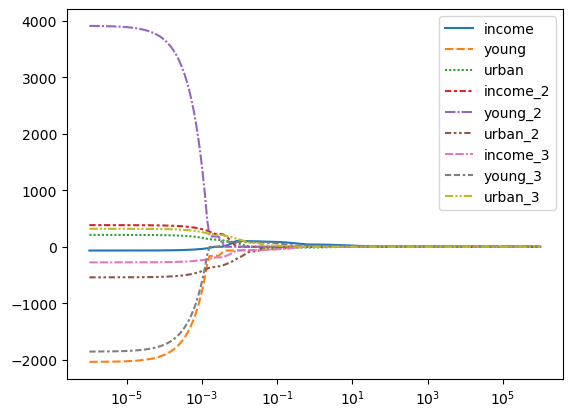

In [6]:
# Lasso coefficients as a function of the regularization paramenter alpha
g = sns.lineplot(data = coefs)
g.set(xscale='log')
plt.show()

In [11]:
# Lasso Mean Squared Error as a function of the regularization paramenter alpha
g = sns.lineplot(x = alphas, y = errors)
g.set(xscale='log')
plt.show()

NameError: name 'alphas' is not defined

## Lasso x Ridge Regression (the book calls the regularization parameter $\lambda$) 

Selection property of lasso: 

- Lasso and ridge are equivalent to a constraint on the shape of the acceptable parameter space.

- But the "diamond shape" of lasso makes it shrinks some coefficients towards zero.

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/lassovsridge3.png?raw=true)

## Lasso x Ridge Regression (the book calls the regularization parameter $\lambda$) 

Lasso performs similarly to ridge in most cases. In these cases, I'd say that lasso is better:

- Reduces the complexity in the model.

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/lassovsridge1.png?raw=true)

## Lasso x Ridge Regression (the book calls the regularization parameter $\lambda$) 

But when all coefficients are different from zero, then ridge is better.

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/lassovsridge2.png?raw=true)

XXXX talk about elasticnet? XXXX

## Lasso x Ridge Regression

To summarize, none is better in all situations.

- But you should know now that this is true for most ML algorithms.

You may need to search which model is better.

Moreover, finding $\alpha$ is also a big deal. Cross-Validation can help us with that!

## Cross-Validation

To select the tuning parameters you can use cross-validation.

The idea is to search through a grid of tuning parameter candidates, selecting the one that does best in the cross-validation.

It is indeed a very straight-forward idea, if you think about it.

In [8]:
## Lasso with Cross-Validation
lasso = Lasso(max_iter = 20000000)
coefs = list()
errors = list()
CVerrors = list()
alphas = np.logspace(-6, 6, 200)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 12345)

for a in alphas:
    lasso.set_params(alpha = a).fit(X_train, y_train)
    CVerrors.append(np.mean((lasso.predict(X_test) - y_test) ** 2))
    errors.append(np.mean((lasso.predict(X_train) - y_train) ** 2))

print('The alpha that minimizes the Lasso Cross-Validation MSE is: ' + str(alphas[CVerrors.index(min(CVerrors))]))
    
mses = pd.DataFrame({
    'trainMSE': errors,
    'testMSE': CVerrors}, index = alphas)

The alpha that minimizes the Lasso Cross-Validation MSE is: 0.1011637979766207


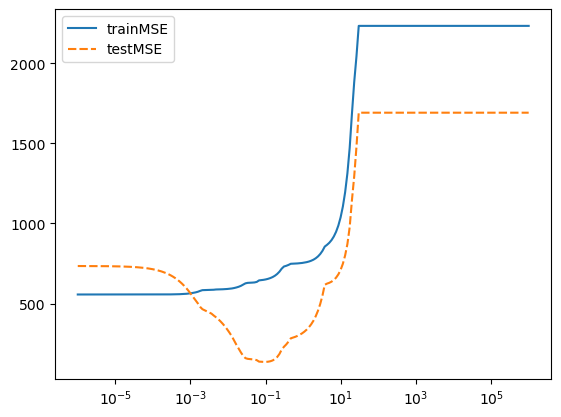

In [9]:
# Cross Validation Lasso MSE as a function of the regularization parameter alpha
g = sns.lineplot(data = mses)
g.set(xscale='log')
plt.show()

# Questions?

# See you next class
